In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as py

from PIL import Image
from scipy.integrate import odeint

%matplotlib inline

## Data Collected

In [68]:
# Here we load the data that we need to make the numerical simulator.

# This data set contains all the isotopes that will be used 
ISOTOPES = pd.read_csv("ISOTOPES",) 

# This data set contains the isotopes, their half-lives, decay constants
# and the fission yileds from the spontaneous fission of 252Cf
HLDC = pd.read_csv("HL&DC",) 

# This data set shows the relation among all different isotopes
BranchingRatiosData = pd.read_csv("BranchingRatiosData",) 

# We will use the data frame HLDC to make  a new one that only contains the isotopes id and
# the half-lives

IsotopesHalfLives = HLDC[["Isotopes","Half Lives (sec)"]] 

## Thresholds

In [69]:
# Since we are only intersted in decays longer than 1.0*10^-3 sec and less than 3600 sec
# we need to apply two thresholds

In [70]:
# Threshold 1
# This function will stop the deacy chain when isotopes have a cartain half-life or longer.
# This values is declared as "th1"


def CutDecayChain(BranchingRatiosData, HalfLivesDatSet, Th1):
    
    IsotopesMeetThreshold=HalfLivesDatSet["Half Lives (sec)"] > Th1
    
    #We put the isotopes that meet the thrshold in a list "Isotopes_High_Halfife"
    Df1_new=HalfLivesDatSet.loc[IsotopesMeetThreshold]
    Isotopes_High_Halfife = Df1_new["Isotopes"].tolist()
    
    
    # We now use the isotopes Id's that are on the list created
    # to find the columns that will be dropped in the data frame that contains the data "BranchingRatiosData"
    
    # C1 and C2 contain the conditions needed to identify the columns to be dropped 
    # These columns are stored in variable A 

    C1=BranchingRatiosData["Fission Products"].isin(Isotopes_High_Halfife)
    C2=BranchingRatiosData["Branching Ratios"] != -1

    A=BranchingRatiosData[C1 & C2]

    #We now update the the data frame by creating a list with the isotpes to be dropped and dropping them from the data.

    Aindexes = A.index.values.tolist()
    BranchingRatiosData.drop(Aindexes, axis=0, inplace=True)
    
    return BranchingRatiosData
    

In [71]:
# Here we apply threshold 1 to update our data and later apply threshold 2.

BranchingRatiosData = CutDecayChain(BranchingRatiosData, IsotopesHalfLives, 3600)

In [72]:
# Threshold 2 iterates through the data and skips short lived isotopes for a certain threshold
# To do this three functions were made, 

In [73]:
# Function one: iterates through the data once skipping shortived isotopes

def SkipShortLivedIsotopes(FatherDaughterRelation, IsotopesHalfLives, Threshold):
    
    # This gives us the condition to get the isotopes that meet the threshold
    IsotopesMeetThreshold = IsotopesHalfLives["HL"] < Threshold

    # This creates a list of the isotopes that meet the threshold
    IsotopeListMeetThreshold = IsotopesHalfLives[IsotopesMeetThreshold]["In"].tolist()

    # Isotopes with  negative BR indicate the decay of the isotope itself not the decay to another isotope.
    # Here this condition gives us the rows that show the decay from one isotope to another
    IsotopesWithPositiveBranchingRatio = FatherDaughterRelation["BR"] != -1

    # Here we determine if the isotopes that meet the threshold are daughter isotopes and will have to be skipped
    DaughterIsotopesMeetThreshold = FatherDaughterRelation["D"].isin(IsotopeListMeetThreshold)

    # This condition shows if the shortlived isotopes are father isotopes
    ShortLivedFatherIsotopes = FatherDaughterRelation["F"].isin(IsotopeListMeetThreshold)


    ConflictingSet=FatherDaughterRelation[DaughterIsotopesMeetThreshold & IsotopesWithPositiveBranchingRatio].reset_index(drop=True)

    
    # Now we find the counts of the short lived daughter isotopes.
    # This indicates how many father isotpes they have which will come in handy later  

    CountsOfShortLivedIsotopes=np.array(ConflictingSet["D"].value_counts())

    # We need to also know if the shortlived daughter isotpes decay to something.
    # To do this we can check in the first data frame if these isotopes are Fathers (under "F")
    # This is the key portion of the data frame as it needs to be updated to replace the Isotopes that meet the threshold
    # (under "F" in this prtion of the data frame) by their respective Father isotopes.
    
    FatherIsotopesToBeUpdated= FatherDaughterRelation[ShortLivedFatherIsotopes & IsotopesWithPositiveBranchingRatio].reset_index(drop=True)

    # An issue is that some isotopes have more than one father isotope which means that apart from changing the father isotopes
    # we need replecate every row by the number of father isotopes that each Shortlived Fatheisotope has, we will make use of 
    # the CountsOfShortLivedIsotopes array since these counts represent the number of father isotopes for the shortlived father Isotopes


    FatherIsotopesToBeUpdated['Counts'] = FatherIsotopesToBeUpdated.groupby(['F'])['BR'].transform('count')

    # We do the same for the ConflictingSet data frame since it has the father isotopes of the shortlived isotopes
    # and they both need to have the same length

    ConflictingSet['Counts'] = ConflictingSet.groupby(['D'])['BR'].transform('count')


    # Here we now make use of the counts to get the correct repetitions of rows


    ShortLivedIsotopesRightLength = FatherIsotopesToBeUpdated.loc[FatherIsotopesToBeUpdated.index.repeat(FatherIsotopesToBeUpdated.Counts)].reset_index(drop=True)
    FatherIsotopesRightLength = ConflictingSet.loc[ConflictingSet.index.repeat(ConflictingSet.Counts)].reset_index(drop=True)
    
    
    # Another issue that arises is that the order of the father isotopes from the FatherIsotopesRightLength dataframe
    # does not match with the order of the Daughter isotopes from the ShortLivedIsotopesRightLength for each group.
    # Each group being the different shortlived isotopes (Example: shortlivedI1 and shortlivedI2)
    
    # Example of the curent order and how it needs to be formed:
    
    # Current order: shortlivedI1[A,A,B,B], shortlivedI2[C,C,C,D,D,D,E,E,E]
    # Right order: shortlivedI1[A,B,A,B], shortlivedI2[C,D,E,C,D,E,C,D,E]

    # To solve this problem, we can add another column with a numerical order that is easdy to manipluate to the change our
    # data frame (FatherIsotopesRightLength ) to the desire order

    # To generate this list of numbers we will make use of a foor loop and the CountsOfShortLivedIsotopes array and make a list
    # out of it

    Counts_list = CountsOfShortLivedIsotopes.tolist()
    Counts_list
    
    


    ListOfNumbersToGiveOrder=[]

    for i in Counts_list:
        a=np.arange(1,i+1)
        b=a.tolist()*i
        ListOfNumbersToGiveOrder=np.append(ListOfNumbersToGiveOrder,b)
    

    # Here we now use the array that we created and add a colum with the ListOfNumbersToGiveOrder and use it to give it 
    # the correct order

    OrderedFatherIsotopes= FatherIsotopesRightLength[["F","D","BR"]]

    OrderedFatherIsotopes["Order"] = ListOfNumbersToGiveOrder

    OrderedFatherIsotopes=OrderedFatherIsotopes.sort_values(['D', 'Order'], ascending = (True, True)).reset_index(drop=True)


    # We now get rid of the columns that we don't need 
    # Keeping the Branching ratio is important as in the end it will have to be updated along with data frame.
    # For this reason well add the suffix G indicating that this is the grand father data
    # and at the end we will change everything to the same labelings


    OrderedFatherIsotopes=OrderedFatherIsotopes[["F","BR"]].add_prefix('G_').reset_index(drop=True)



    # We do the same for ShortLivedIsotopesRightLength
    # In this case we don't need tp add a suffix

    ShortLivedIsotopesRightLength=ShortLivedIsotopesRightLength[["D","BR"]]




    # Now we need to join the two dataframes and add anew column that will contain the new Branching Ratio


    OrderedFatherIsotopes=OrderedFatherIsotopes.join(ShortLivedIsotopesRightLength)

    OrderedFatherIsotopes["BR_New"] = OrderedFatherIsotopes["G_BR"]*OrderedFatherIsotopes["BR"]


    # Now we get rid of the coulmns we don't need and rena,me the columns to match our original data frame

    UpdatedPortion=OrderedFatherIsotopes[["G_F", "D", "BR_New"]].rename(columns={"G_F": "F", "BR_New": "BR"},)



    # Now that we have an updated portion we need to drop the data frames that needed to be updated from the original data farme
    
    ToBeDropped1 = FatherDaughterRelation[DaughterIsotopesMeetThreshold & IsotopesWithPositiveBranchingRatio].reset_index(drop=True)

    ToBeDropped2 = FatherDaughterRelation[ShortLivedFatherIsotopes & IsotopesWithPositiveBranchingRatio].reset_index(drop=True)


    # we drop them from the original data frame

    UpdatedFatherDaughterRelation=pd.concat([FatherDaughterRelation, ToBeDropped1, ToBeDropped2]).drop_duplicates(keep=False)

    UpdatedFatherDaughterRelation


    # Finally we get updated FatherDaughterRelation Data frame for one full iteration

    FinalFatherDaughterRelation= pd.concat([UpdatedFatherDaughterRelation, UpdatedPortion]).sort_values('F').reset_index(drop=True)
    
    
    RepeatedFatherAndDaughter=FinalFatherDaughterRelation[ (FinalFatherDaughterRelation["BR"] != -1) & (FinalFatherDaughterRelation["F"] == FinalFatherDaughterRelation["D"])]
    
    
    FinalFatherDaughterRelation=pd.concat([FinalFatherDaughterRelation, RepeatedFatherAndDaughter]).drop_duplicates(keep=False)

    FatherDaughterRelation = FinalFatherDaughterRelation
    
    return FatherDaughterRelation

In [74]:
# Function 2 will determine how many times we'll have to iterate through the data and apply function 1

def DaughtersToBeSkiped(FatherDaughterRelation, IsotopesHalfLives, Threshold):
    
    # This gives us the condition to get the isotopes that meet the threshold
    IsotopesMeetThreshold = IsotopesHalfLives["HL"] < Threshold

    # This creates a list of the isotopes that meet the threshold
    IsotopeListMeetThreshold = IsotopesHalfLives[IsotopesMeetThreshold]["In"].tolist()


    # Isotopes with  negative BR indicate the decay of the isotope itself not the decay to another isotope.
    # Here this condition gives us the rows that show the decay from one isotope to another
    IsotopesWithPositiveBranchingRatio = FatherDaughterRelation["BR"] != -1


    # Here we determine if the isotopes that meet the threshold are daughter isotopes and will have to be skipped
    DaughterIsotopesMeetThreshold = FatherDaughterRelation["D"].isin(IsotopeListMeetThreshold)

    # This portion of the data frame contains the isotpes that will need to be skipped, as daughters.
    # Here we can see the diferent father isotpopes that they have.

    ConflictingSet=FatherDaughterRelation[DaughterIsotopesMeetThreshold & IsotopesWithPositiveBranchingRatio].reset_index(drop=True)

    Unique_Daughter_values = ConflictingSet["D"].unique()
    
    Length = len(Unique_Daughter_values)
    
    return Length

In [75]:
# Function 3 makes use of the previous two functions to update the entire data and obtain the desired form.

def ApplyThreshold2(FatherDaughterRelation, IsotopesHalfLives, Threshold):
    
    IsotopesMeetThreshold=DaughtersToBeSkiped(FatherDaughterRelation, IsotopesHalfLives, Threshold)
    
    Updated = SkipShortLivedIsotopes(FatherDaughterRelation, IsotopesHalfLives, Threshold) 
    
    while IsotopesMeetThreshold > 0:
        
        Updated = SkipShortLivedIsotopes(Updated, IsotopesHalfLives, Threshold)
        IsotopesMeetThreshold=DaughtersToBeSkiped(Updated , IsotopesHalfLives, Threshold)
        
        if IsotopesMeetThreshold == 0:
            break;   
            
    return Updated

In [76]:
# To make sure that our functons work properly when we use them,
# we will have to rename the labels of our data frames so that they agree with the ones used in the data frame
# *This step can be skipped if the original data is renamed to the correct form *


# We use the temprary variables Data1, Data2 and Data3 to rename the labels our data.  

Data1=BranchingRatiosData.rename(columns={"Fission Products": "F", "Daughter Nuclides": "D", "Branching Ratios":"BR",})
Data2=IsotopesHalfLives.rename(columns={"Isotopes":"In","Half Lives (sec)":"HL"})

# We apply the threshold 2
# Here any decay with a halflife less than 0.01 will be skipped

Data3=ApplyThreshold2(Data1, Data2, 0.01)

# Here we now rename the labels as their original names. 

BranchingRatiosData=Data3.rename(columns={"F":"Fission Products","D":"Daughter Nuclides","BR":"Branching Ratios"})

# Decay chains


In [77]:
#Using a pivot table allows us to relate the barnching ratios of every single isiotope with one another

pivottable=BranchingRatiosData.pivot_table(values='Branching Ratios',index='Daughter Nuclides',columns='Fission Products').fillna(0)

#pivottable

In [78]:
# We also need to consider de deacy constant of the isotopes and include them in trhe pivot table.
# Also to solve the system of differential equations that we will create we need to turn the pvot table into a matrix

var = [ ]
for column in pivottable:
    var.append ( pivottable[ column ].tolist () )

for row in var :
    print(row)
    
Matrix=[]
    
result = [[var[j][i] for j in range(len(var))] for i in range(len(var[0]))]

Matrix=np.array(result)

#Matrix

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [79]:
# The following lists contain important data that we will use

# This list contains the decay constant values of all isotpes in our data following the order found in the data frame
DecayConstantVals=np.array(HLDC["Decay Constant"])

# This list conatins the fission yields values of 252Cf 
FYVals=np.array(HLDC["Fission Yields"])

# This list contains the name of the isotopes in our data
# Since the data conatins the name of the isotopes with spaces between the quotation marks, the following piece of code
# gets rid of that space so taht it looks better


ISOIDs = np.array(ISOTOPES["Isotopes"]).tolist()

ID = []

for i in ISOIDs:
    j = i.replace(' ','')
    ID.append(j)

In [80]:
# This is the data that we will use , it takes into account the branching ratios and decay constants of the isotpes. 

FinalMatrix=Matrix*DecayConstantVals
FinalMatrix

array([[-9.24196241e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000, -1.01933409e+001,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000, -1.47478124e+001, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       ...,
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
        -6.93147181e-101,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000, -6.93147181e-101,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000, -6.93147181e-101]])

In [81]:
# This piece of code sets the system of diff eqs and uses odeint to solve them.
# Here the span of time needs to be indicated

def deriv(A, t, Ab):
    return np.dot(Ab, A)

t = np.linspace(0,3600,5000)
MA = odeint(deriv, FYVals, t, args=(FinalMatrix,))


In [82]:
# This fucntions allows us to plot the time evolution of the fission products by indicating the ID of the isotope
# ID of isotope 'Z-N'

def TimeEvolve(x):
    N=0
    for i in ID:
        if x == i:
            N+=1
        
            A=ID.index(i)
        
            fig, ax = plt.subplots()
        
            ax.plot(t, MA[:, A],'seagreen' ,lw=1.5, ls='-', marker='o', markersize=5, label= x)
        
            ax.grid()
            ax.legend()
        
            ax.set_title('252Cf Fission Products Time Evolution', fontsize=14)
            ax.set_xlabel('Time (sec)', fontsize=14)
            ax.set_ylabel('Radiactive amount of isotope', fontsize=14)
            
            #ax.set_yscale('log')
            #ax.set_xscale('log')
        
            fig.set_figwidth(9)
            fig.set_figheight(6)
        
            plt.yticks(fontsize=12)    
            plt.xticks(fontsize=12)
        
            plt.show()
        
    if N == 0:
        print("I don't know that sotope")

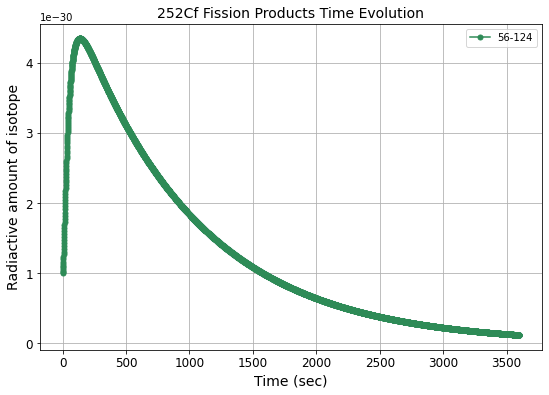

In [83]:
Isotope = '56-124'

TimeEvolve(Isotope)